In [1]:
%matplotlib inline
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import utils.figure_utils as utils
from utils.curlyBrace import curlyBrace
import nengo
from offline_rl_networks import ValueCritic, sparsity_to_x_intercept

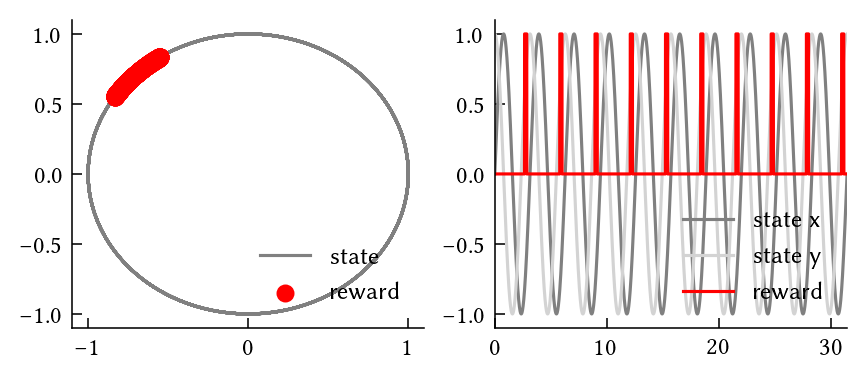

In [2]:
T=np.pi*10
dt = 0.001
timesteps = np.arange(0,T,dt)

def sim_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = sim_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards

rewards = reward_fun(timesteps)

plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

In [3]:

T = 30*np.pi
T_test = 0.7*T
n_neurons_state=200
n_neurons_value=100
discount = 0.8


q_s = 12
q_r = 8
q_v = 8

learn_schedule=[2,1]
theta = 2.1
n_max = T_test // (learn_schedule[0] + learn_schedule[1])
def sim_fun(t):   
    n = t // (learn_schedule[0] + learn_schedule[1])
    m = (t - n*(learn_schedule[0] + learn_schedule[1])) // learn_schedule[0] 
    if isinstance(t, np.ndarray):
        tnew=t.copy()
        tnew[m>0] = (n[m>0] + m[m>0])*learn_schedule[0] 
        tnew[m<=0] -= n[m<=0]*learn_schedule[1] 
        tnew[t>T_test] = t[t>T_test] - n_max*learn_schedule[1] 
        t = tnew
    else:
        if t < T_test:
            t = (n + m)*learn_schedule[0]  if m>0 else t - n*learn_schedule[1]
        else:
            t =  t - n_max*learn_schedule[1]
    return np.stack([np.sin(t*2), np.cos(t*2)]).T

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards


model = nengo.Network(seed=0)
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)


    VL = ValueCritic(n_neurons_state, n_neurons_value, theta, 2, discount, q_s, q_r, q_v,'TDtheta',
                     learn_schedule=learn_schedule, replay_type="backward",
                     T_test=T_test,learning_rate=2e-4,intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    rrecall_p = nengo.Probe(VL.recalled_r, synapse=None)
    s_p = nengo.Probe(VL.state, synapse=.05)
    smem_p = nengo.Probe(VL.state_memory, synapse=None)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)

    # lon_p = nengo.Probe(VL.learn_on, synapse=None)
    # sinmem_p = nengo.Probe(VL.state_input, synapse=None)
    # sin_p = nengo.Probe(VL.state_memory_input, synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 
sim_path = sim_fun(ts)
rewards = reward_fun(ts)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

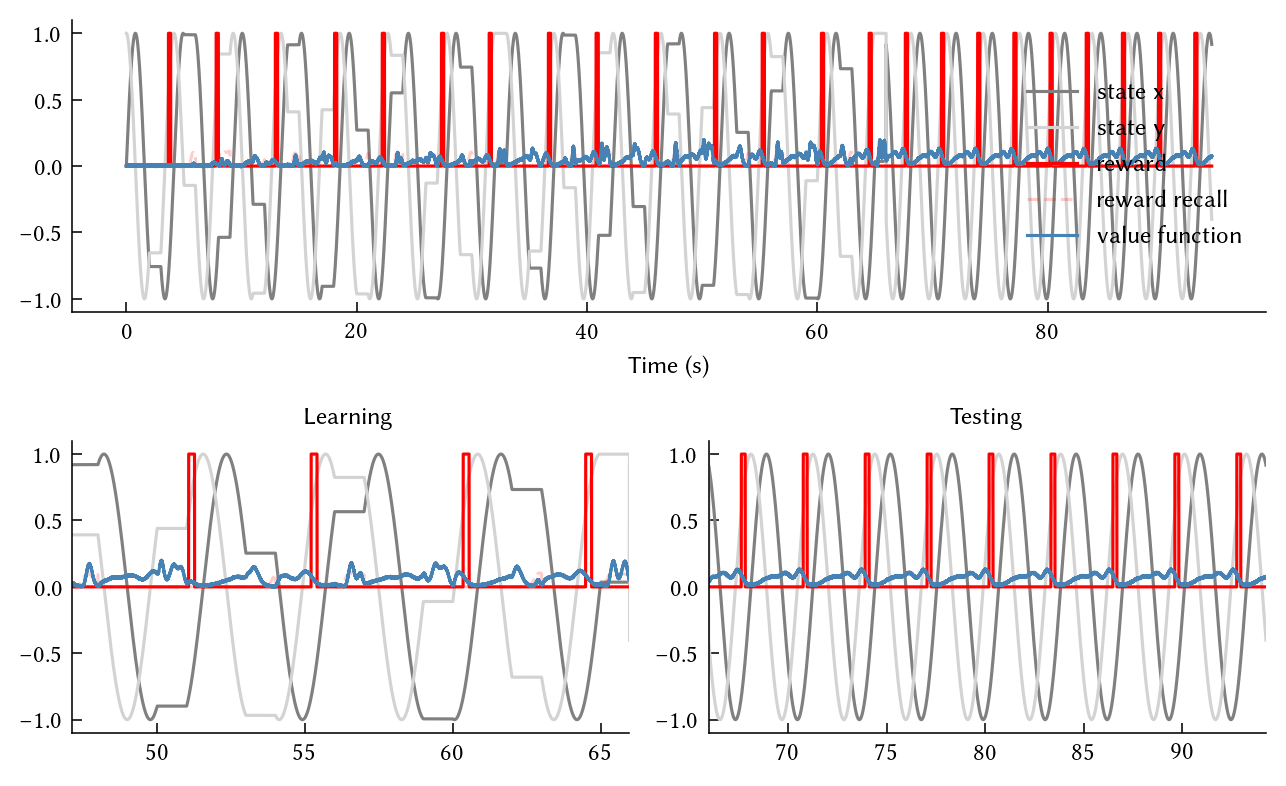

In [4]:
fig = plt.figure( figsize=(6.5,4), tight_layout=True)
gs = gridspec.GridSpec(2,2)

ax = fig.add_subplot(gs[0, :])

ax.plot(ts,sim_path[:,0], label='state x',color='grey')
ax.plot(ts,sim_path[:,1], label='state y',color='lightgrey')
ax.plot(ts,rewards, label='reward', color='red')
ax.plot(ts,sim.data[rrecall_p], '--', label='reward recall', color='red',alpha=0.2)
ax.plot(ts, sim.data[V_p], color='steelblue', label='value function')
ax.legend()
# ax.set_title('TD(0)')
ax.set_xlabel('Time (s)')

ax = fig.add_subplot(gs[1,0])
ax.plot(ts,sim_path[:,0], label='state x',color='grey')
ax.plot(ts,sim_path[:,1], label='state y',color='lightgrey')
ax.plot(ts,rewards, label='reward', color='red')
ax.plot(ts,sim.data[rrecall_p], '--', label='reward recall', color='red',alpha=0.2)
ax.plot(ts, sim.data[V_p], color='steelblue', label='value function')
ax.set_xlim([0.5*T,T_test])
ax.set_title('Learning')

ax = fig.add_subplot(gs[1,1])
ax.plot(ts,sim_path[:,0], label='state x',color='grey')
ax.plot(ts,sim_path[:,1], label='state y',color='lightgrey')
ax.plot(ts,rewards, label='reward', color='red')
ax.plot(ts, sim.data[V_p], color='steelblue', label='value function')
ax.set_xlim([T_test,T])
ax.set_title('Testing');


Saving to tdtheta_backwardreplay.large.pdf
Extracting bounding box of file tdtheta_backwardreplay.large.pdf
Optimising PDF and saving to tdtheta_backwardreplay.pdf


GPL Ghostscript 9.26: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.26: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.


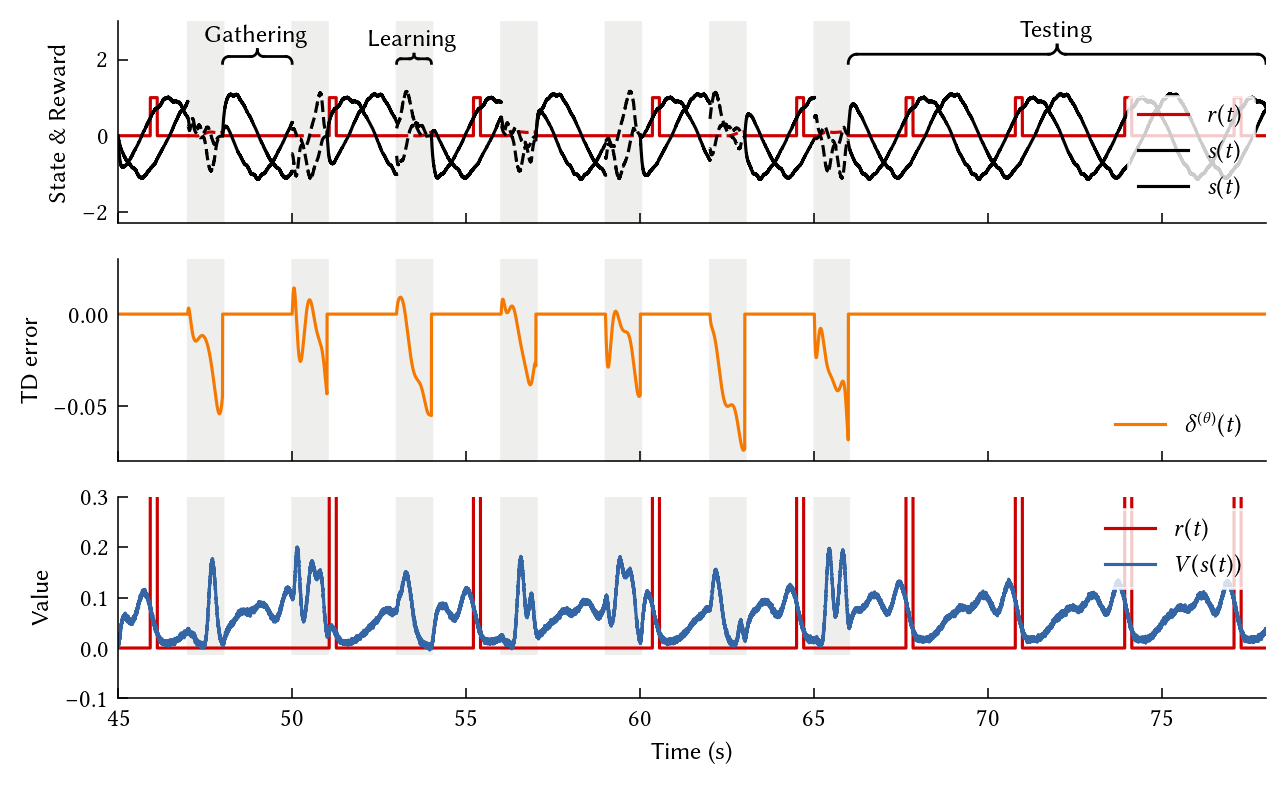

In [5]:

iphs = 15
n_cycles = 8


n_gather = int(learn_schedule[0]/dt)
n_learn = int(learn_schedule[1]/dt)
n_period = n_gather+n_learn
n_test = n_period*4

assert dt*(iphs+n_cycles)*n_period >= T_test
assert dt*iphs*n_period < T_test

fig, axs = plt.subplots(3,1, figsize=(6.5,4), tight_layout=True, sharex=True)
for i in range(3):
    axs[i].set_xlim(iphs*n_period*dt, T_test + n_test*dt)

ylims0 = [-2.3,3]
ylims1 = [-0.08,0.03]
ylims2 = [-0.01, 0.4]
axs[0].set_ylim(ylims0)
axs[1].set_ylim(ylims1)
axs[2].set_ylim(ylims2)

curlyBrace(fig, axs[0],  [(iphs+1)*n_period*dt, 1.9],
           [((iphs+1)*n_period + n_gather)*dt, 1.9],
           0.09, bool_auto=False, str_text='Gathering', color='k', lw=1, int_line_num=1);
curlyBrace(fig, axs[0],  [((iphs+2)*n_period+n_gather)*dt, 1.9],
           [(iphs+3)*n_period*dt, 1.9],
           0.12, bool_auto=False, str_text='Learning', color='k', lw=1, int_line_num=1);
curlyBrace(fig, axs[0],  [T_test, 1.9],
           [T_test + n_test*dt, 1.9],
           0.02, bool_auto=False, str_text='Testing', color='k', lw=1, int_line_num=1);

for i in range(n_cycles):
    endt = int(np.minimum(((iphs+i+1)*n_gather + (iphs+i)*n_learn),int(T_test/dt)))
    axs[0].plot(ts[(iphs+i)*n_period:endt], 
                 sim.data[r_p][(iphs+i)*n_period:endt], color=utils.reds[1], alpha=1)
    axs[0].plot(ts[(iphs+i)*n_period:endt], 
                 sim.data[s_p][(iphs+i)*n_period:endt], color='k')
    
    
    endt = int(np.minimum((iphs+i+1)*n_period,int(T_test/dt)))
    plttime=ts[((iphs+i+1)*n_gather + (iphs+i)*n_learn):endt]

    axs[0].fill_between(plttime,ylims0[0],ylims0[1],color=utils.grays[-1])
    axs[1].fill_between(plttime,ylims1[0],ylims1[1],color=utils.grays[-1])
    axs[2].fill_between(plttime,ylims2[0],ylims2[1],color=utils.grays[-1])
    js = np.linspace(0,1,len(plttime))
    res =  [sim.data[smem_p][((iphs+i+1)*n_gather + (iphs+i)*n_learn)] @ VL.state_lmu_transform(j).T for j in js]
    # axs[0].plot(plttime,  res, '--',color='k')
    axs[0].plot(plttime,  sim.data[rrecall_p][((iphs+i+1)*n_gather + (iphs+i)*n_learn):endt], '--', color=utils.reds[1], alpha=1)
    axs[0].plot(plttime,  (1/2)*sim.data[s_p][((iphs+i+1)*n_gather + (iphs+i)*n_learn):endt], '--',color='k')
    
axs[0].plot(ts[int(T_test/dt):(int(T_test/dt) + n_test)], sim.data[r_p][int(T_test/dt):(int(T_test/dt) + n_test)], color=utils.reds[1],label='$r(t)$')

axs[0].plot(ts[int(T_test/dt):(int(T_test/dt) + n_test)], sim.data[s_p][int(T_test/dt):(int(T_test/dt) + n_test)], color='k',label='$s(t)$')
axs[1].plot(ts[iphs*n_period:(int(T_test/dt) + n_test)], sim.data[er_p][iphs*n_period:(int(T_test/dt) + n_test)], color=utils.oranges[1],label='$\delta^{(\\theta)}(t)$')

axs[2].plot(ts[iphs*n_period:(int(T_test/dt) + n_test)], sim.data[r_p][iphs*n_period:(int(T_test/dt) + n_test)], '-', color=utils.reds[1], alpha=1,label='$r(t)$')
axs[2].plot(ts[iphs*n_period:(int(T_test/dt) + n_test)], sim.data[V_p][iphs*n_period:(int(T_test/dt) + n_test)], color=utils.blues[1],label='$V(s(t))$')
axs[2].set_xlabel('Time (s)')
axs[0].set_ylabel('State \& Reward')
axs[1].set_ylabel('TD error')
axs[2].set_ylabel('Value')
axs[2].set_ylim([-0.1,0.3])

axs[0].legend(loc='lower right',frameon=True,edgecolor='white')
axs[1].legend(loc='lower right',frameon=True,edgecolor='white')
axs[2].legend(loc='upper right',frameon=True,edgecolor='white')


# fig.text(0.2, 0.93, '\\textbf{A}', size=12, va="baseline", ha="left")
utils.save(fig,'tdtheta_backwardreplay.pdf')